
# <center> 02807 - Computational Tools for Data Science </center>  

# <center> Week 14 <center>



# <center> Today: Intro to Streaming <center>

Goals for today's lecture

* Understanding the concept of a **data stream** 
* Understanding the characteristics of a **streaming algorithms** 
* **Sampling representatively** and finding **majority elements** in a stream 
* Presentation of Project 3


# What is a data stream?

* A real-time, continuously growing, data sequence. 

* Elements of the stream arrive one at a time.

* It is impossible to control the order in which data elements arrive.

* It is unfeasible to locally store a stream in its entirety.


## Example: **Twitter** data 

* Tweets arrive in real time

* Can't control the order in which they arrive

* Can't store all tweets: around **500 million** tweets are generated daily ([Source](https://www.dsayce.com/social-media/tweets-day/#:~:text=Every%20second%2C%20on%20average%2C%20around%206%2C000%20tweets%20are%20tweeted%20on,August%202014%20with%20661%20million.))

<img src="https://www.flaticon.com/svg/static/icons/svg/124/124021.svg" width="100">

# More examples

* Social media feeds
* Stock price monitoring
* Sensor data
* Bank transactions
* Road traffic monitoring

# Data Streaming Model

**Stream**:  sequence of $m$ elements $⟨x_1,x_2,...,x_m⟩$ growing over time
  * stream at time-step 1: $⟨x_1⟩$
  * stream at time-step 2: $⟨x_1,x_2⟩$
  * etc.

**Goal**: Compute some function of stream, e.g., median, number of distinct elements, smallest element.

**Catch**:
1. Limited memory: 
  * Cannot store all elements we see 
  * Need a data structure that uses limited space (much smaller than $m$)
2. Access data sequentially: get one item at a time
3. Process each element quickly: fast updates on the data structure


# Examples of simple operation on streams: finding the minimum

* Imagine our data is a list of integers.
* We want to find out the minimum of this list. 
* In a setting with batch data, you solve it like this:

In [1]:
import numpy as np

data = np.random.randint(low=0,high=20,size=10)
print("Data:", data)

print("Minimum:", np.min(data))

Data: [ 4 15  0 15 16 12 14  1  3  6]
Minimum: 0


* But this assumes that ``data`` is in memory already. 
* How can we approach this if ``data`` is a stream?

```
1. Read first element and declare it the minimum. 
2. Read the second element.
   If it is smaller than the current minimum (first element):
       declare it the minimum. 
   Else:
       do nothing.
3. Read you read the third element.
   If it is smaller than the current minimum:
       declare it the minimum. 
   Else:
       do nothing.
```

You can see where this is going!

# Does it count as a streaming algorithm?

* Limited memory? **Yes**. Only store one element (current minimum) at any single time
* Access data sequentially? **Yes**. 
* Process each element quickly? **Yes**, only two numbers checked at any point in time


In [2]:
from math import inf

class StreamingMinimum:
    def __init__(self):
        self.result = inf  # Immediately replaced by the 1st element

    def update(self, element):
        self.result = min(self.result, element)

In [3]:
import numpy as np

stream = np.random.randint(low=0,high=20,size=10)  # Simulate a stream
print("Data:", stream)

s = StreamingMinimum()

for element in stream: # read next element of stream
    s.update(element) # update minimum element

print(s.result)

Data: [ 5 17  5  6 18 16 13 19  5 15]
5


The algorithm works because the minimum can be computed incrementally over the stream:


<img src="https://miro.medium.com/max/1400/1*lcxBq9PE_nX791mRs-tXrQ.png" width="600" class="center">

# Sampling a stream

* **Stream sampling** is the process of collecting a representative sample of the elements of a data stream. 

* Sample is usually much smaller than the entire stream, but can be designed to retain important characteristics of the stream, and can be used to estimate many important aggregates on the stream. 

* Crucial for many streaming applications


## Sampling batch data

* Imagine that you have a dataset and you want to uniformly sample an object
* How to do this? 
* If you know the size $n$ of the data set, you can uniformly draw a random number $k$ between $1$ and $n$, scan the data set and take the $k$-th element.


In [4]:
from random import randrange

data = np.random.randint(low=0,high=20,size=10)  # Simulate a stream
print("Data:", data)
k = randrange(10)
print("k:", k)
sample = data[k]
print("Sample", sample)

Data: [ 3 14  7 12  6  6 18  9 13 16]
k: 3
Sample 12


## Sampling a data stream

* But now imagine that you have a data stream 
* How do you take a sample from a stream of unknown length? 
* You don't know which range to draw your random index from. 
* This problem has a nice solution, called **Reservoir Sampling**.

## Reservoir Sampling

* **Problem**: Uniformly sample an element $s$ from a stream $(a_1,a_2,...)$ of unknown length. Make sure $n$-th element $a_n$ is selected with probability $1/n$.

* **Algorithm**:

```
1. Read first element a_1 and set s=a_1.
2. On seeing the n-th element a_n:
    with probability (1/n), update s = a_n (i.e., throw out previous sampled element)
```

<img src="https://miro.medium.com/max/1400/1*aKNfFphkeqkEmivHA3FkDw.png" width="600" class="center">



* Does it work?

 * when $n=1$: $a_1$ selected with probability $\frac{1}{1}$. Good.
 * when $n=2$: 
   * $a_2$ selected with probability $\frac{1}{2}$
   * $a_1$ selected with probability $\frac{1}{1} \times \frac{1}{2}$. Good.
 * when $n=3$: 
    * $a_3$ selected with probability $\frac{1}{3}$
    * $a_2$ selected with probability $\frac{1}{2} \times \frac{2}{3} = \frac{1}{3} $. Good.
    * $a_1$ selected with probability $\frac{1}{1} \times \frac{1}{2} \times \frac{2}{3} = \frac{1}{3} $. Good.

* Key insight: What’s the probability that $s = x_i$ at some time $t \geq i$?

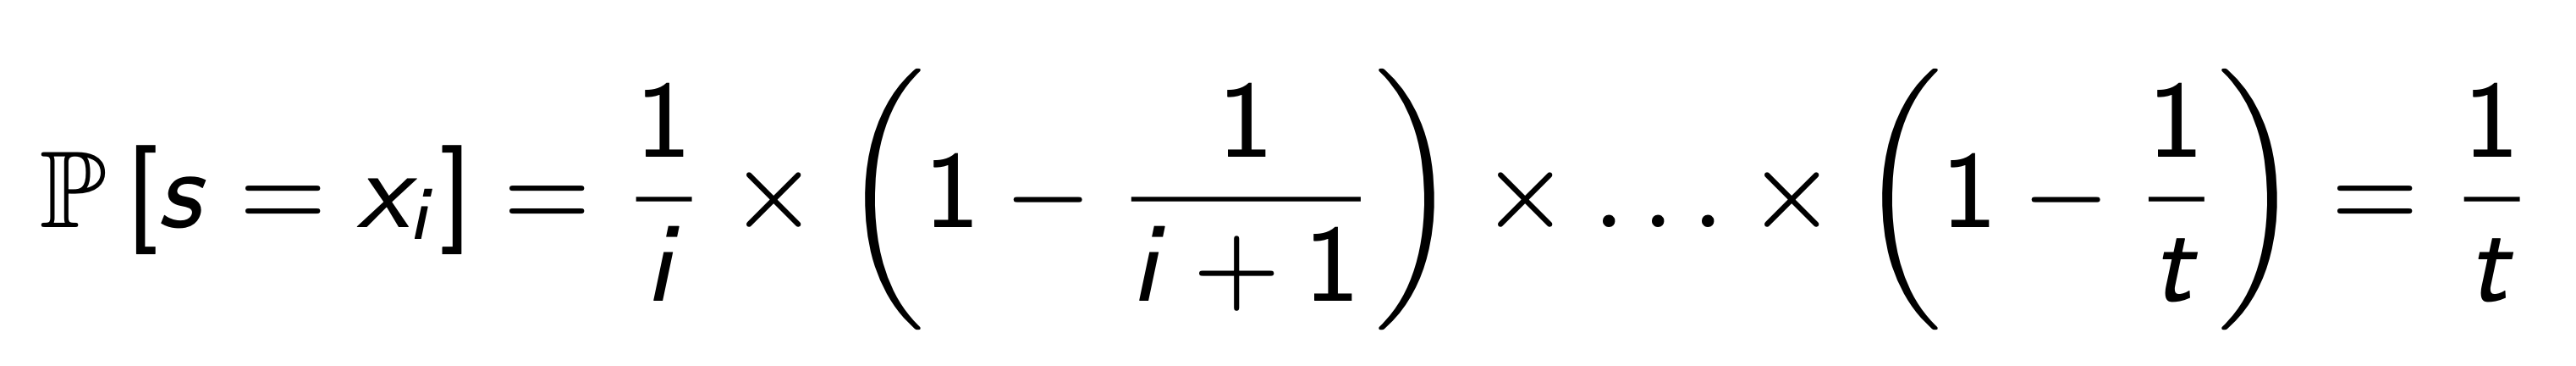



* It seems to work.

* And indeed, it does, as one can prove using induction.

* Let's look at the code.


In [5]:
from random import random

class ReservoirSampler:
    def __init__(self):
        self.sample = None # sampled element
        self.n = 0 # number of elements from stream traversed so far

    def update(self, element):
        self.n += 1     # we see a new stream element
        if random() < 1 / self.n:  # satisfied with prob. 1/n.
            self.sample = element # upldate sample to new stream element

* Let's run an experiment

* 100.000 times, we'll sample the stream `range(20)` using the method above.

* We'll record the number sampled each time after traversing the entire stream. 

* And the result is...

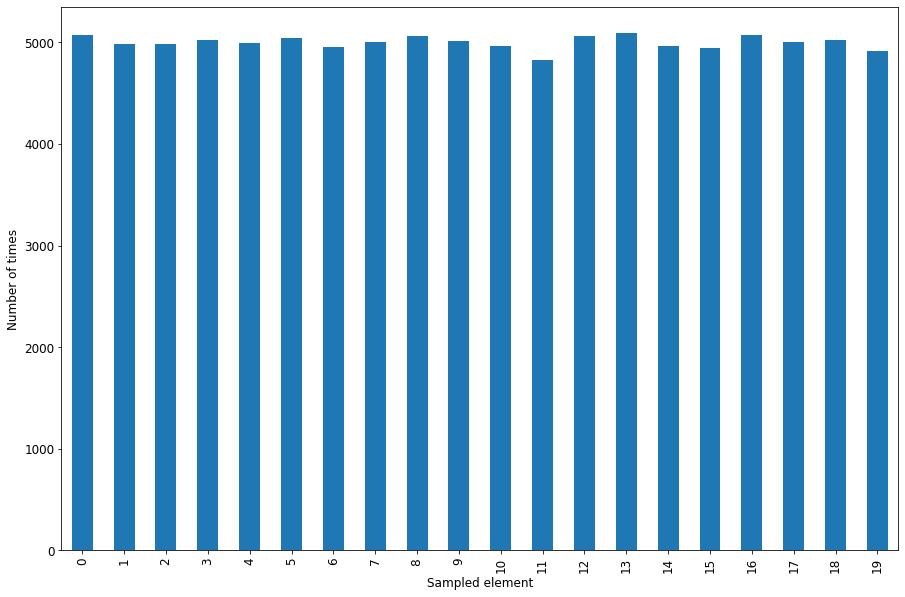

## Does it count as a streaming algorithm?

* Limited memory? **Yes**. Only store two things (current sample, number of stream elements seen) at any single time.
* Access data sequentially? **Yes**. 
* Process each element quickly? **Yes**, only requires a biased coin toss at each time-step.

## Reservoir sampling with a reservoir of size $k$

* The method described above samples $1$ element from the stream. That is, it has a reservoir of size $1$.

* In its general form, reservoir sampling generates a sample of $k$ elements from the stream. 

# Computing frequent elements 

A very useful statistic for many streaming applications is to keep track of elements that occur frequently. 

* This type of problem come in several flavours.

- *Mode* : Find the element (or elements) with the highest frequency.
- *Majority*: Find the element with strictly more than 50% occurrence in the stream - note that there may not be a majority elements in a stream.
- *Threshold:* Find all elements that occur more than $f$ fraction of the stream
for any $0 < f \leq 1$. Finding majority is a special case with $f > 1/2$.

## Examples

* Which IP is accessing the website most often?
* Who is posting the majority of the tweets?

## Boyer–Moore majority vote algorithm 

* An algorithm for finding the majority element in a stream, if it exists.

```
Initialize a majority candidate m with m = None 
Initialize a counter c with c = 0
For each element x of the input stream:
  If c = 0:
    assign m = x and c = 1
  else if m = x (x is already the majority element):
   then assign c = c + 1
  else (x is not the majority element and c != 0):
   assign c = c − 1
Return m
```



## Example with two candidates: A and B

**Stream** (8 elements): AABBBAAA

* Majority element: A (5 votes)

Initialisation 


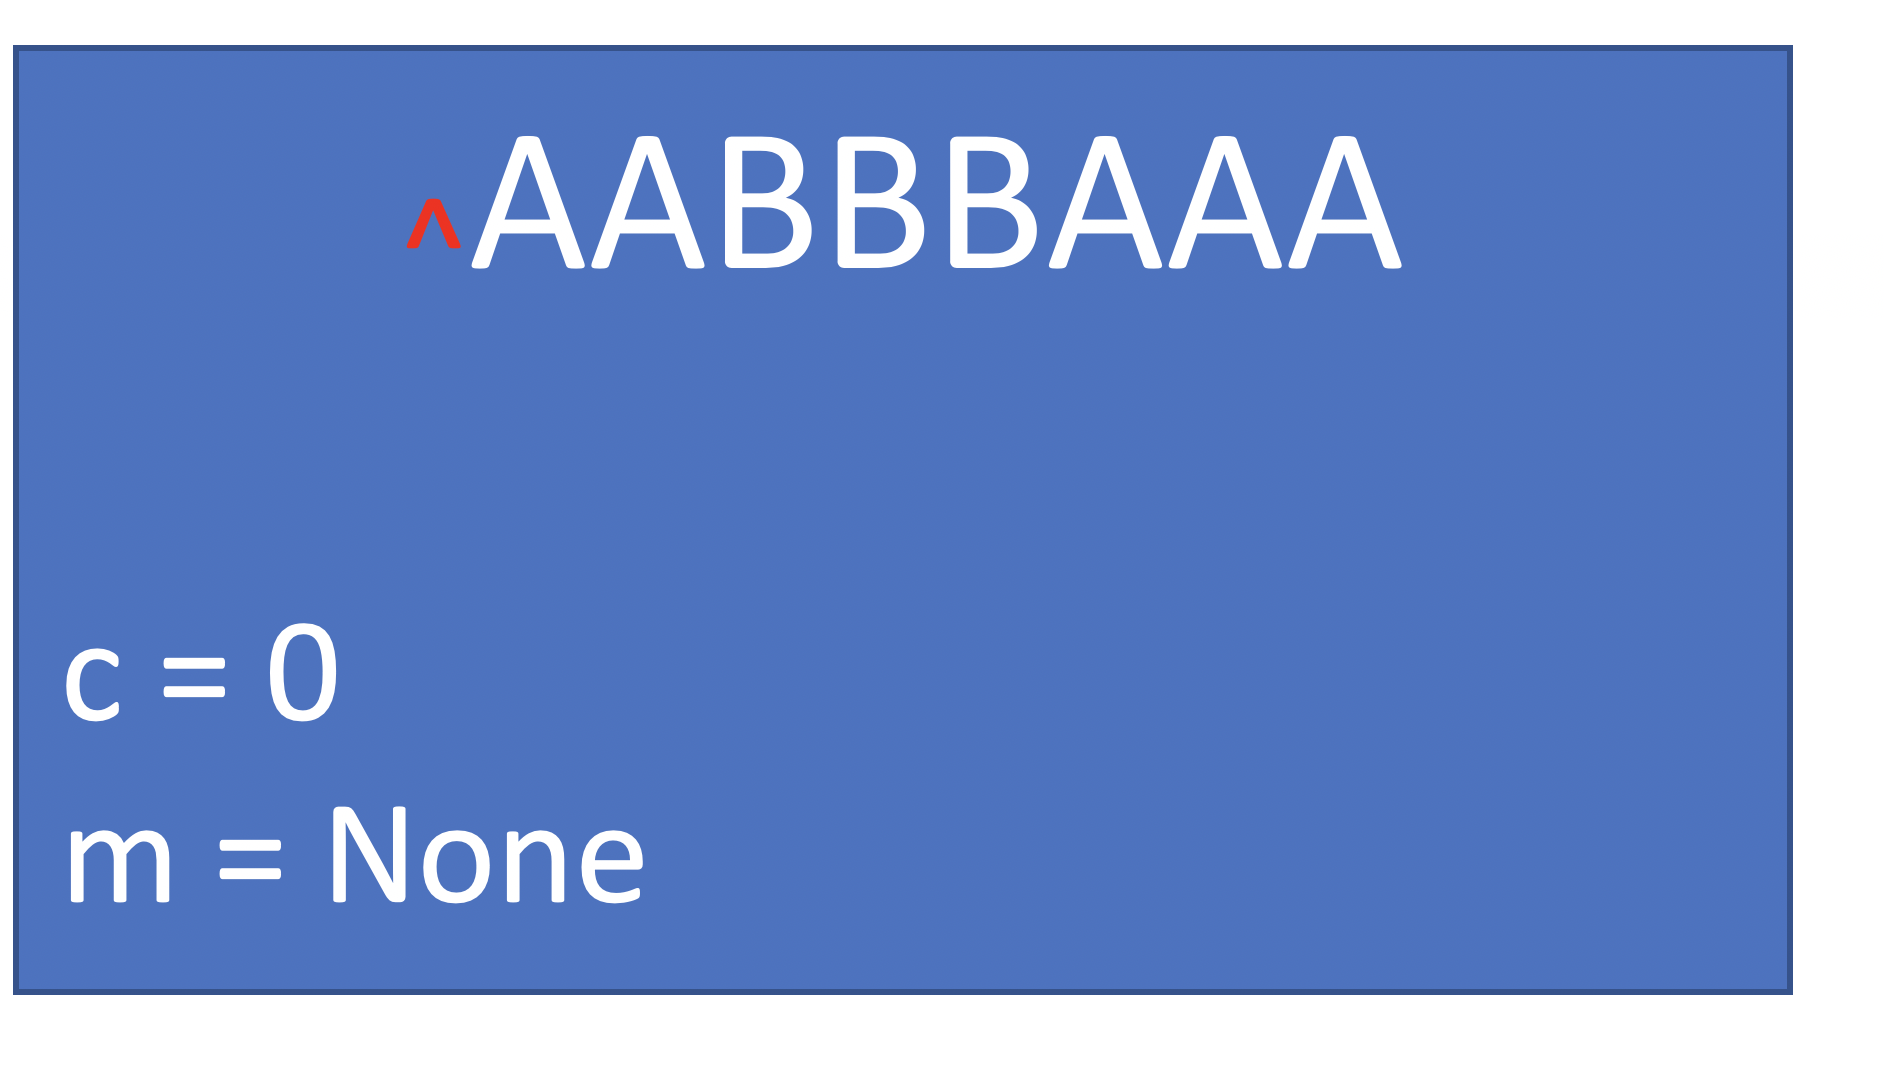

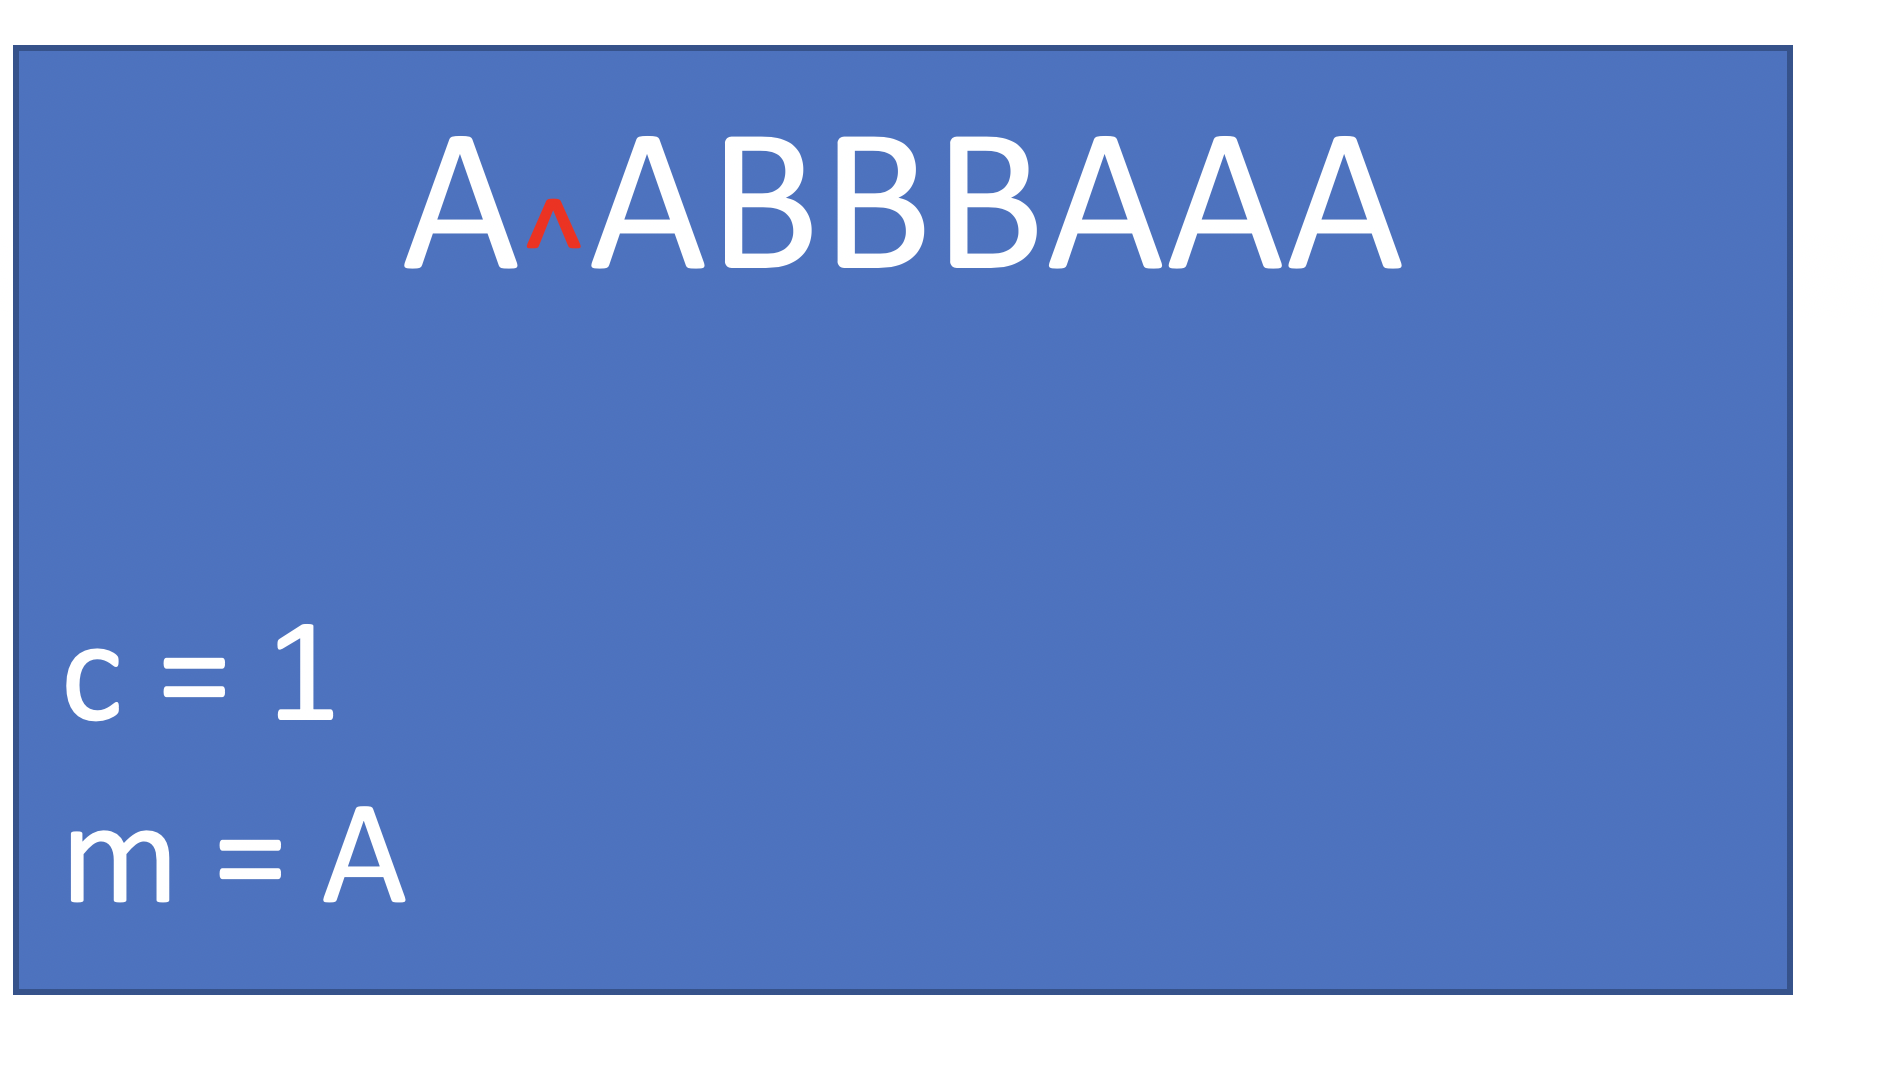


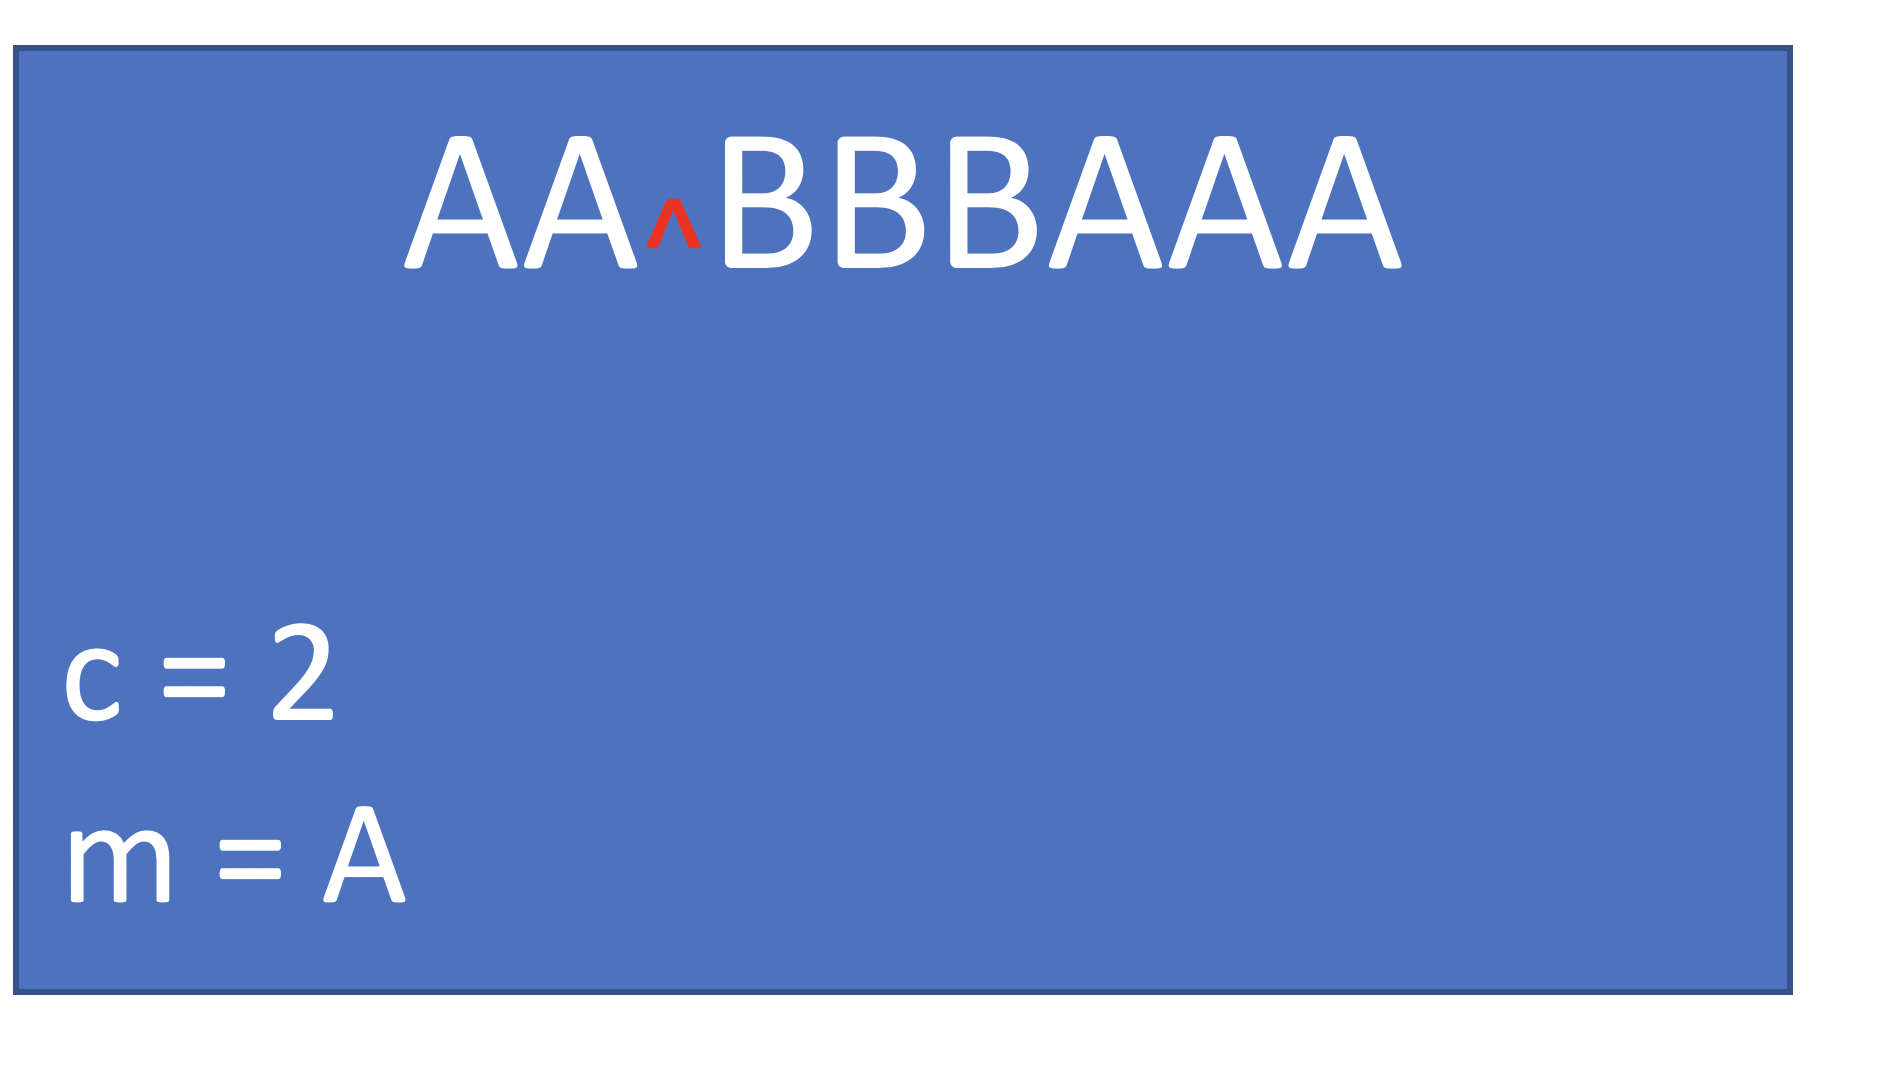

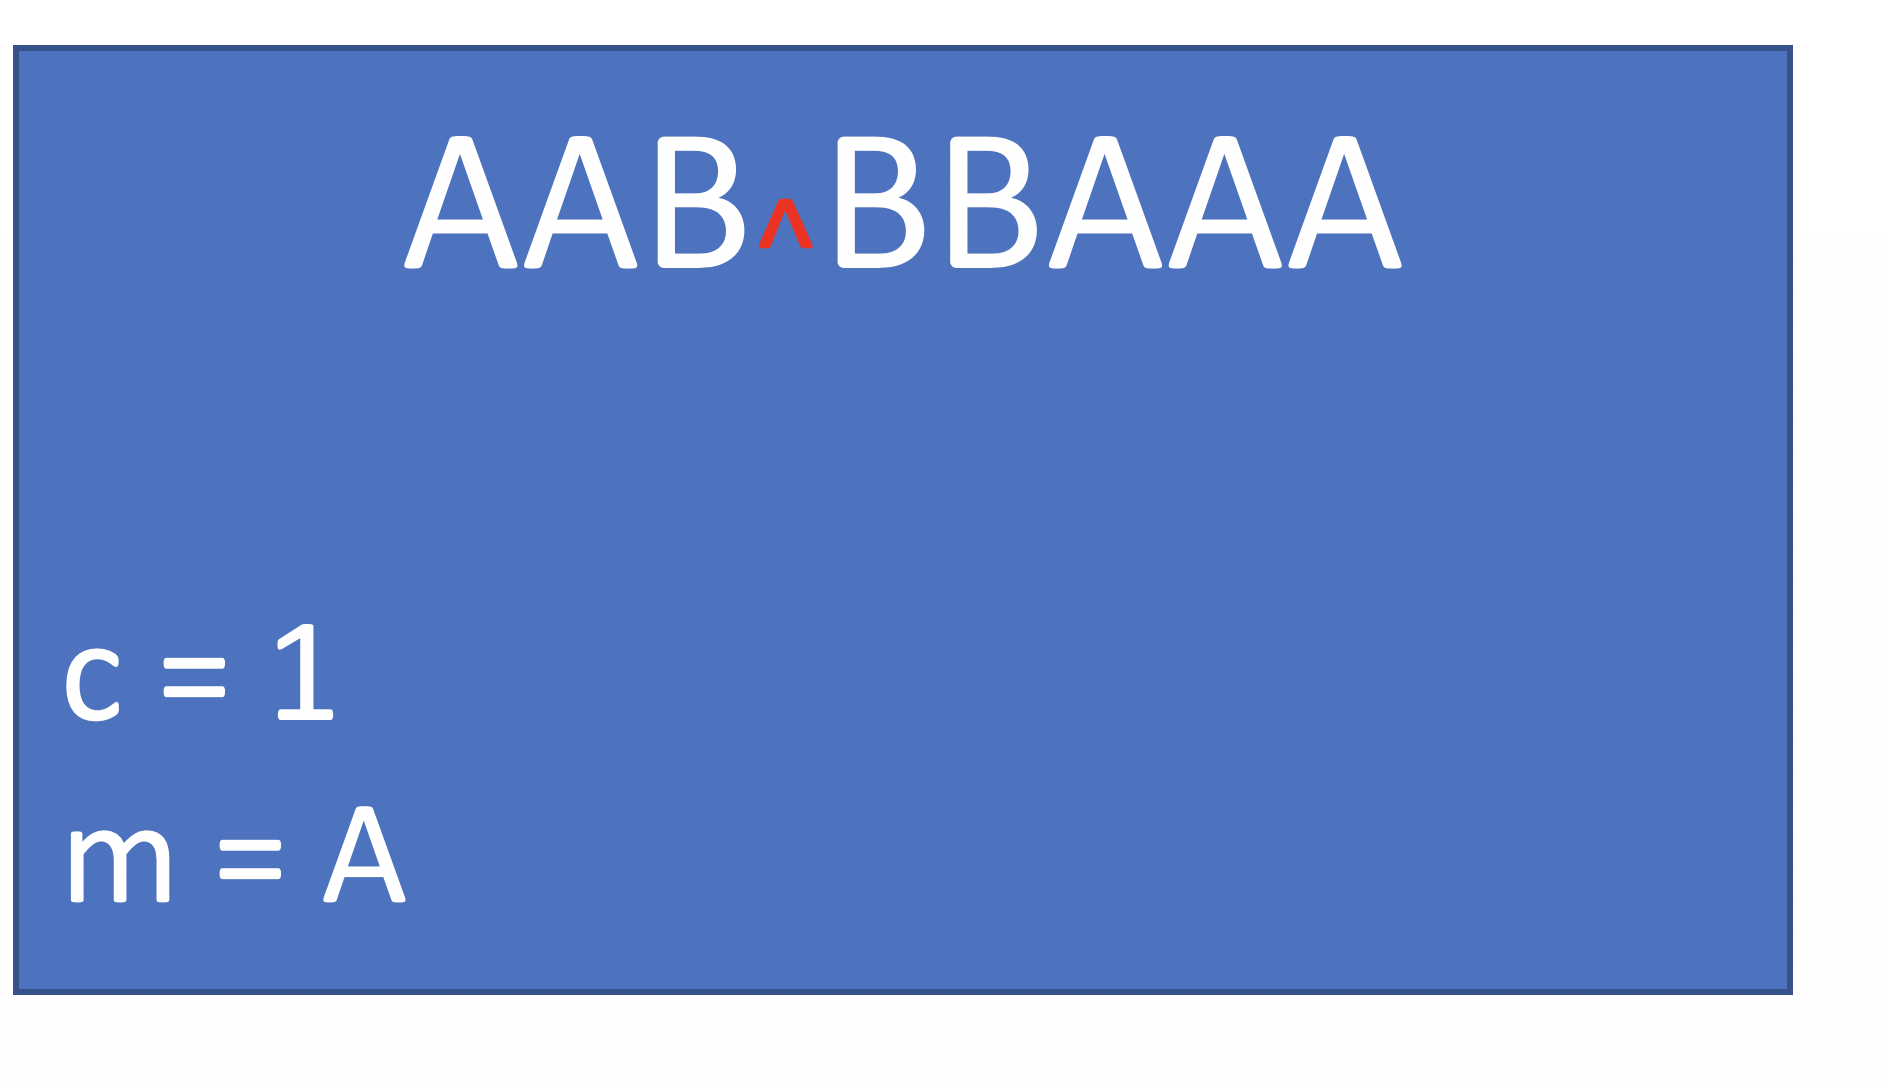

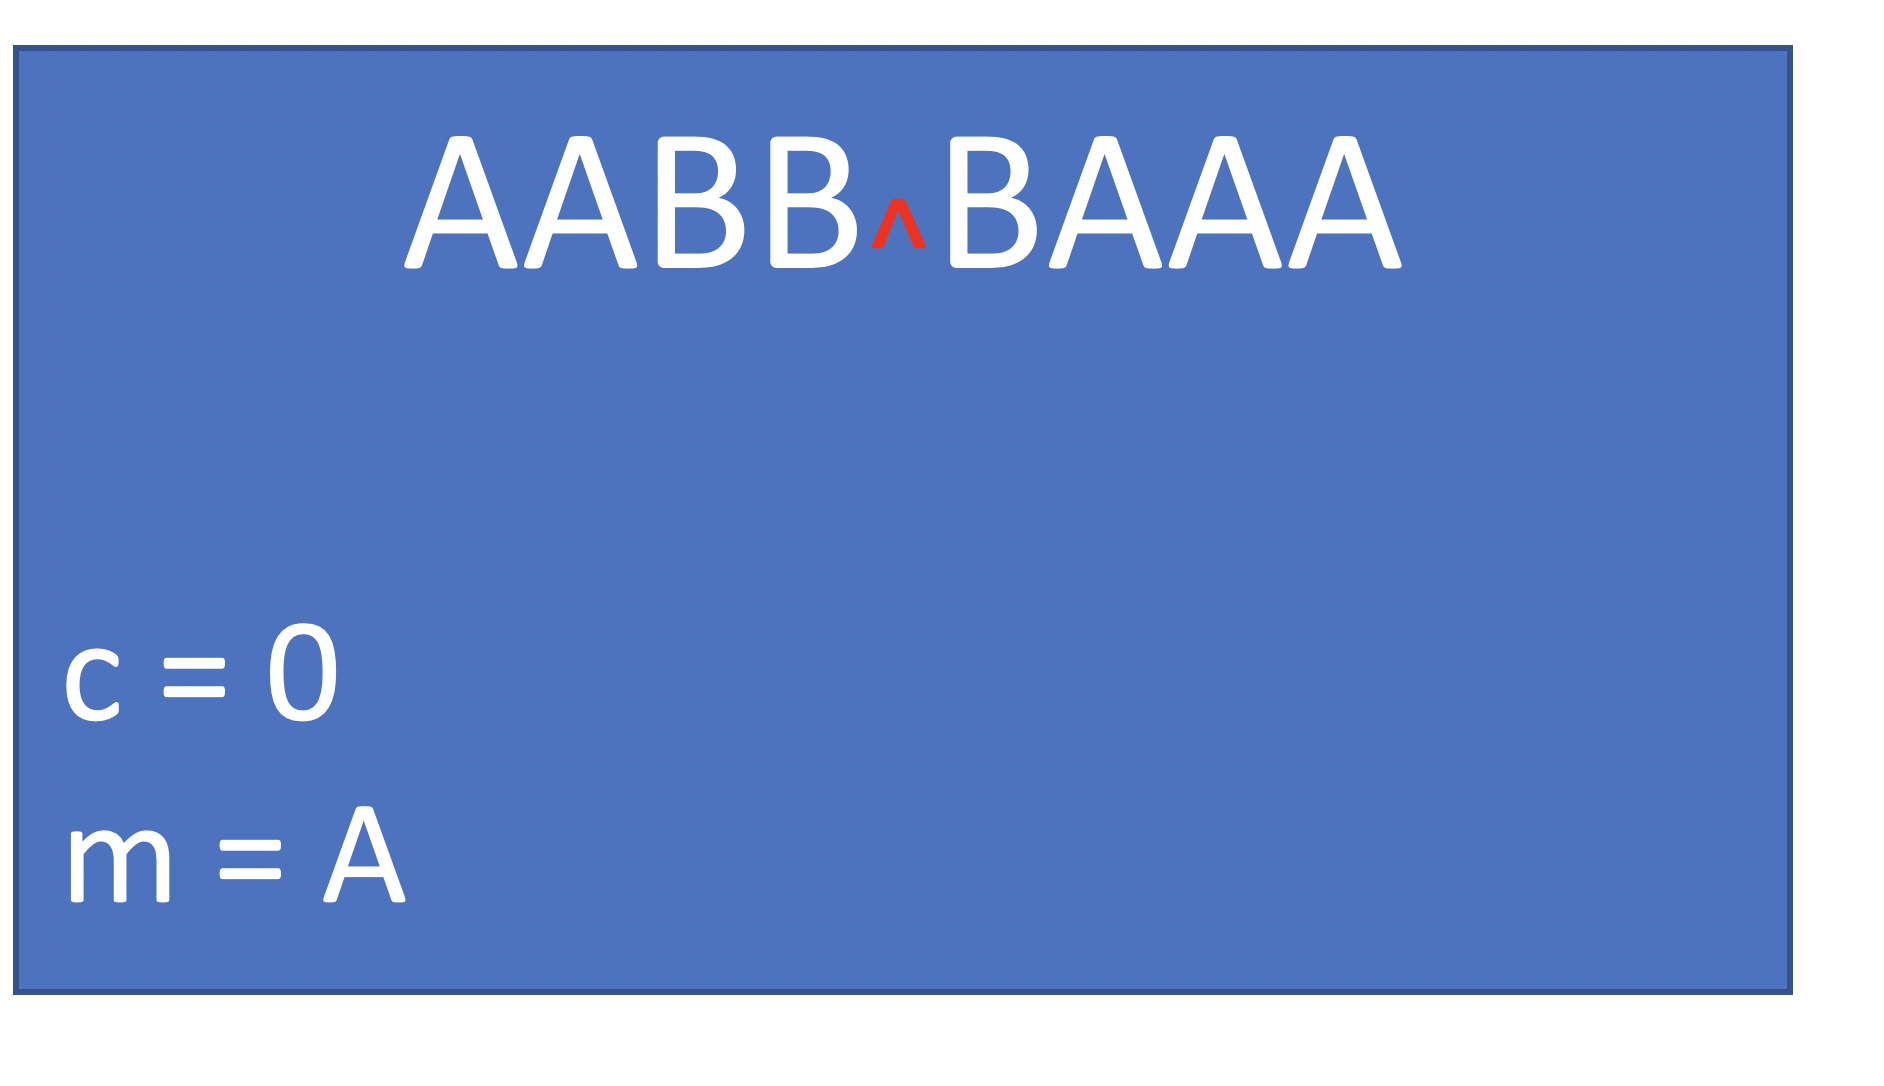

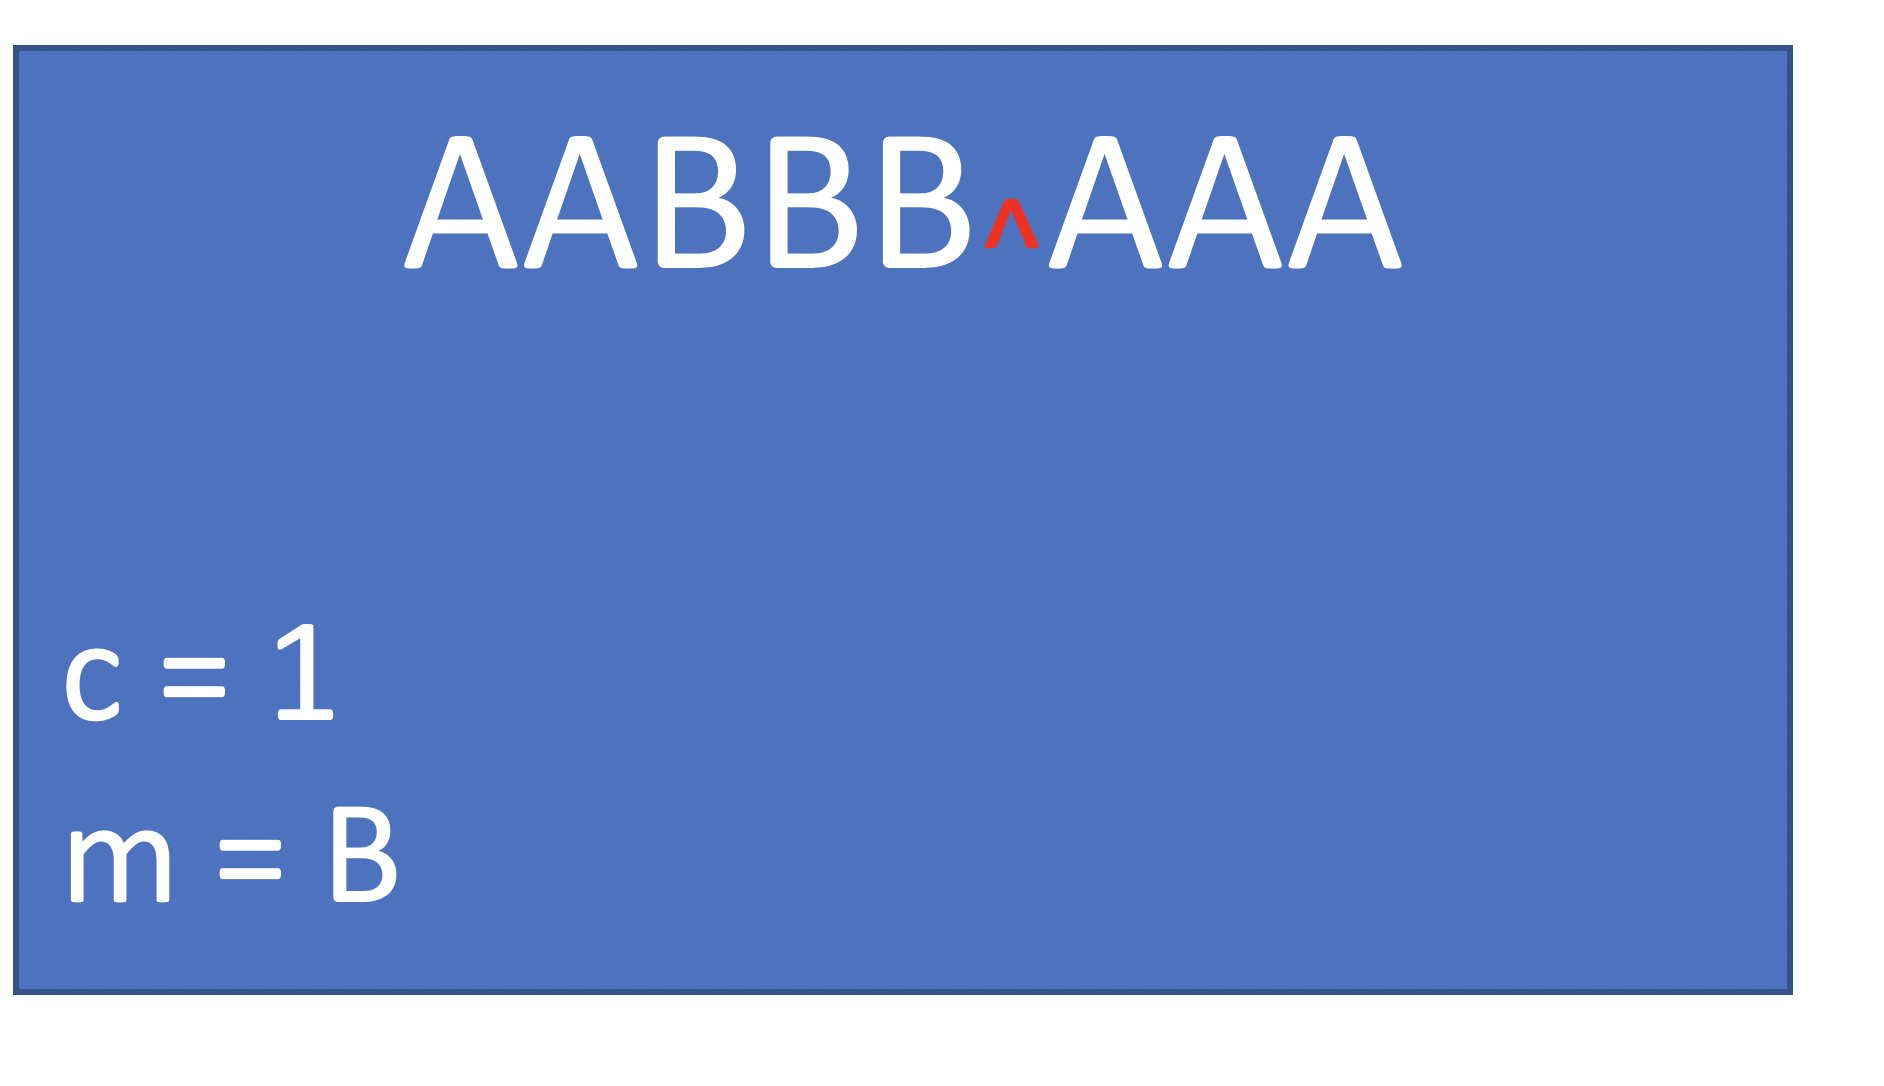

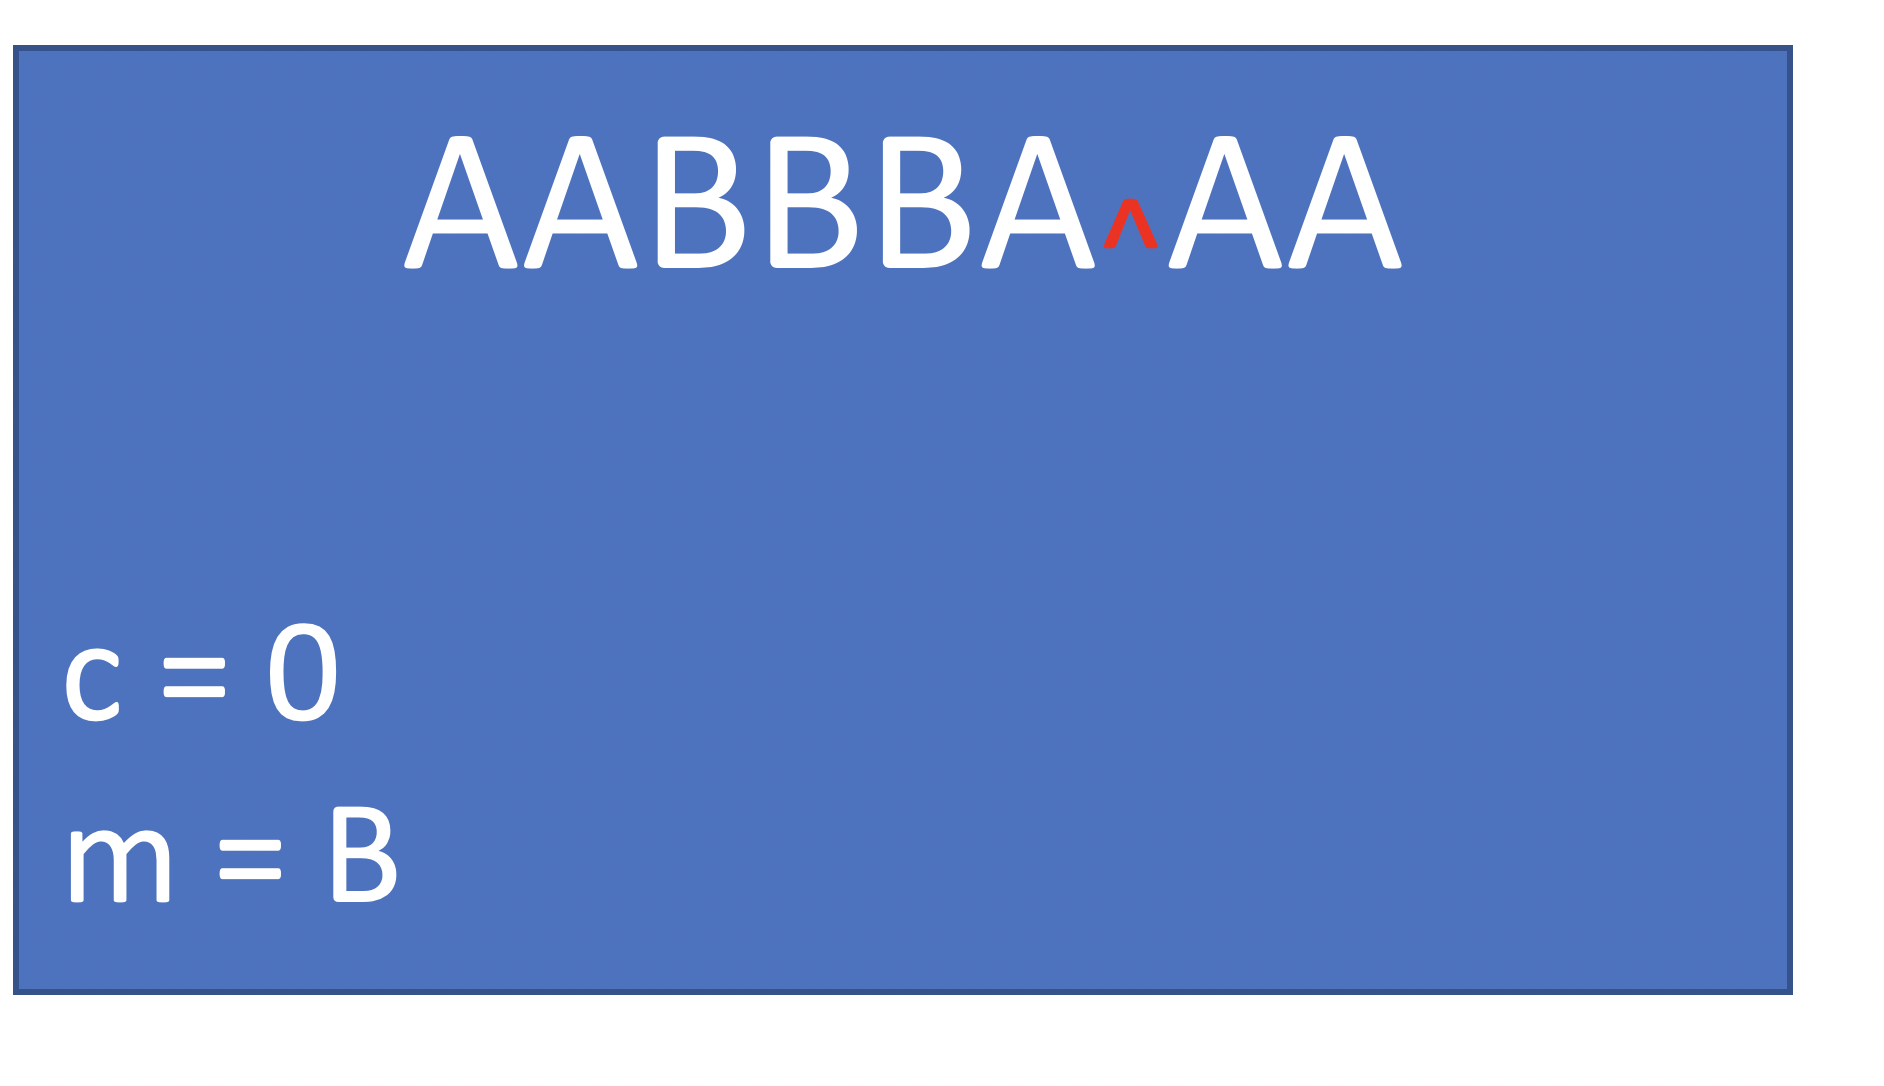

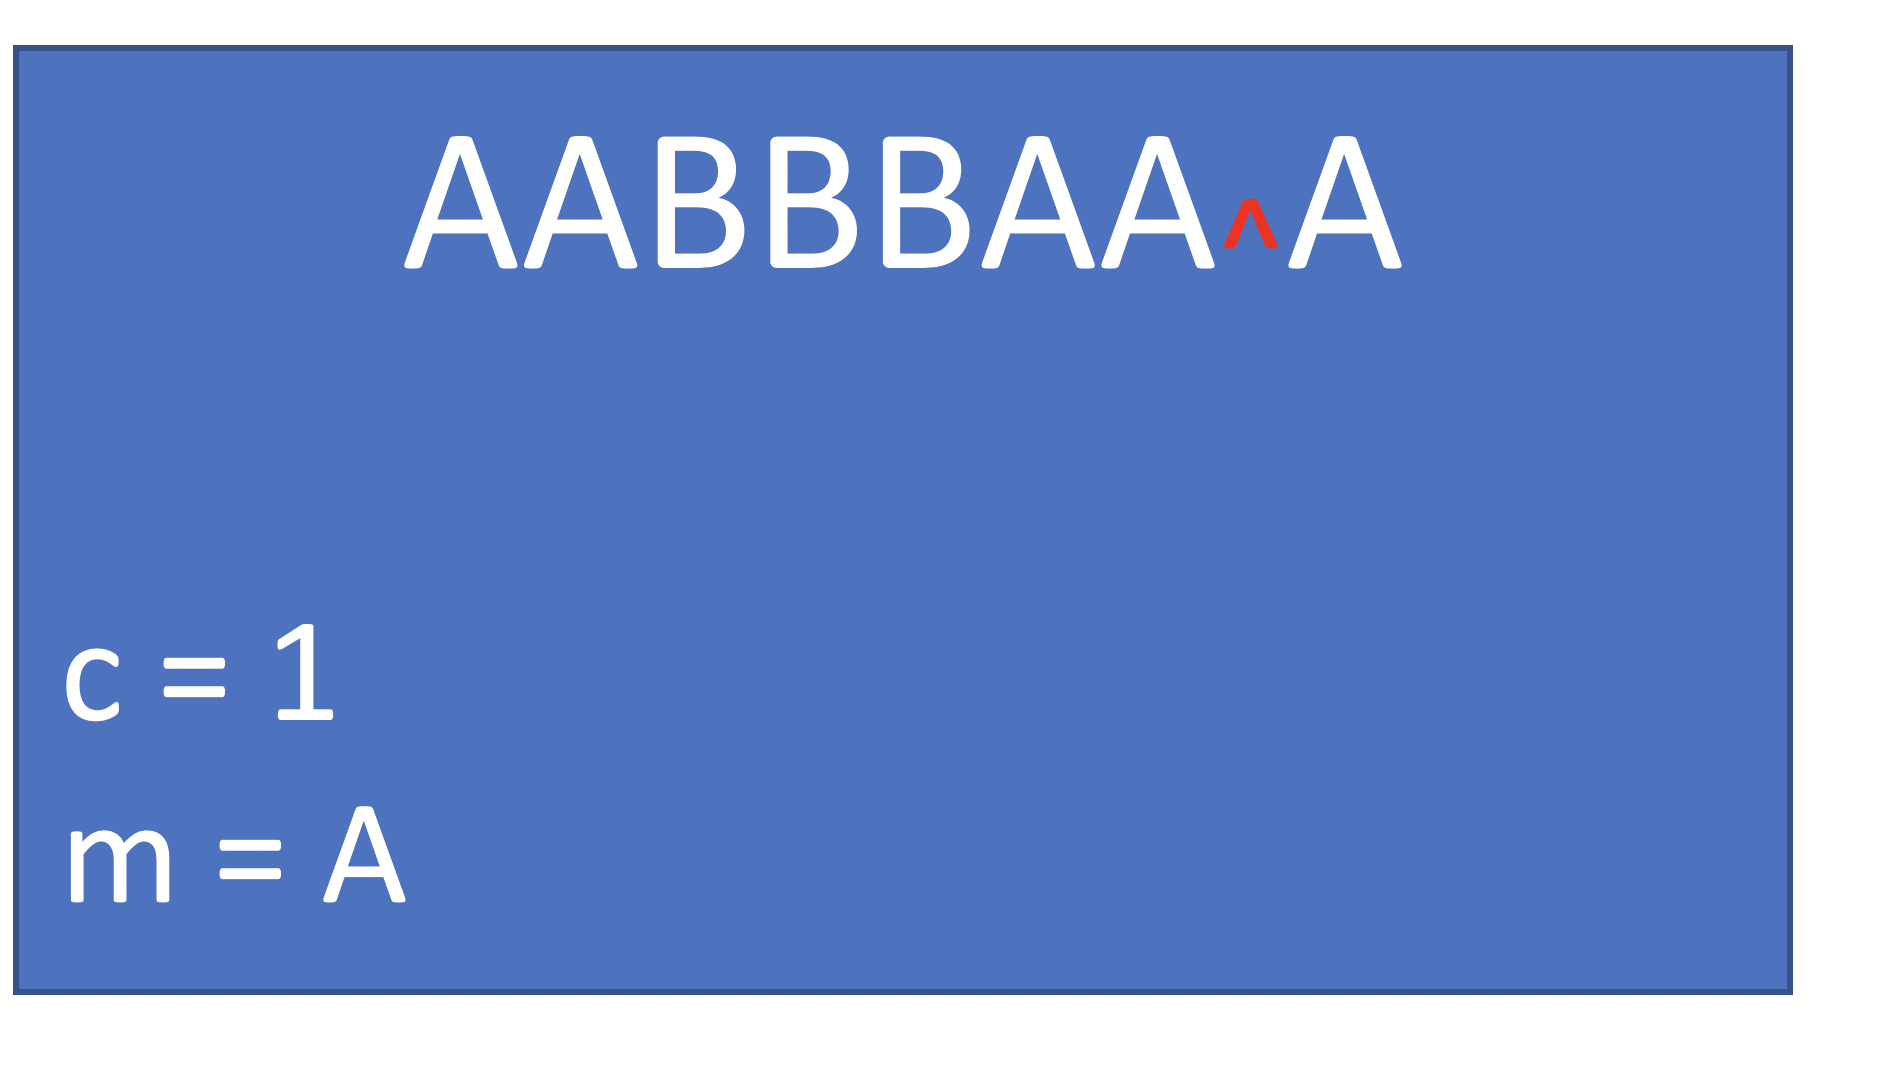

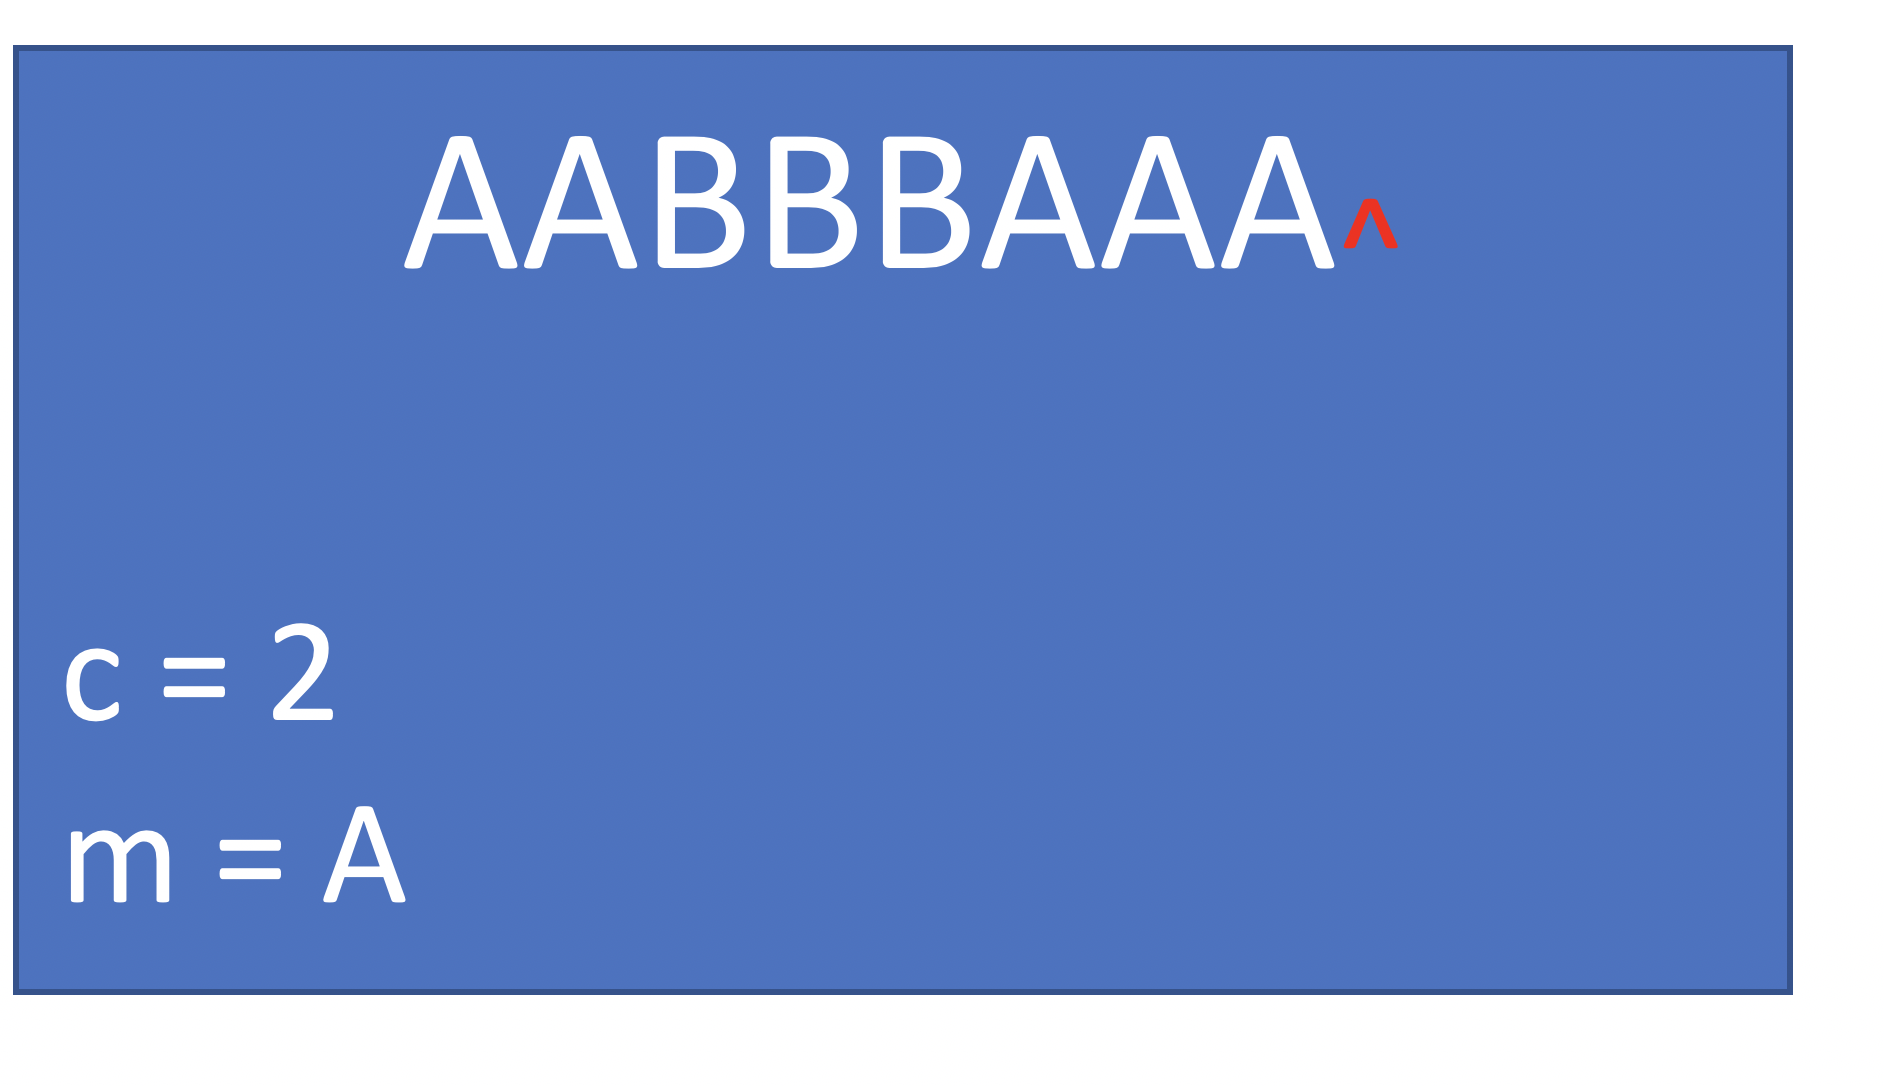

## Does it count as a streaming algorithm?

* Limited memory? **Yes**. Only store two things (current majority candidate, and counter) at any single time.
* Access data sequentially? **Yes**. 
* Process each element quickly? **Yes**, few equality comparisons and increment/decrement operations.

## Properties of Boyer-Moore

* If the Boyer–Moore majority vote algorithm returns ``majority_element`` $e$, it either holds that $e$ is the majority element or there isn't a majority element.
* Can give false positives: no majority element exists, but ``m`` is not ``None``.
* The algorithm can be modified to avoid false positives.

